Satellite images are returned by Python AWIPS as grids, and can be rendered with Cartopy pcolormesh the same as gridded forecast models in other python-awips examples. 

In [80]:
%matplotlib inline
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import datetime

DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("satellite")

### Available Satellite Sectors and Products

In [81]:
availableSectors = DataAccessLayer.getAvailableLocationNames(request)
availableSectors.sort()

print("\nAvailable sectors and products\n")
for sect in availableSectors:
    request.setLocationNames(sect)
    availableProducts = DataAccessLayer.getAvailableParameters(request)
    availableProducts.sort()
    print(sect + ":")
    for prod in availableProducts:
        print("  - "+prod)


Available sectors and products

Alaska National:
  - Imager 11 micron IR
  - Imager 6.7-6.5 micron IR (WV)
  - Imager Visible
  - Percent of Normal TPW
  - Rain fall rate
  - Sounder Based Derived Precipitable Water (PW)
Alaska Regional:
  - Imager 11 micron IR
  - Imager 3.9 micron IR
  - Imager 6.7-6.5 micron IR (WV)
  - Imager Visible
East CONUS:
  - Imager 11 micron IR
  - Imager 13 micron (IR)
  - Imager 3.9 micron IR
  - Imager 6.7-6.5 micron IR (WV)
  - Imager Visible
  - Low cloud base imagery
GOES-East:
  - Imager 11 micron IR
  - Imager 13 micron IR
  - Imager 3.5-4.0 micron IR (Fog)
  - Imager 6.7-6.5 micron IR (WV)
  - Imager Visible
GOES-East-West:
  - Imager 11 micron IR
  - Imager 13 micron IR
  - Imager 3.5-4.0 micron IR (Fog)
  - Imager 6.7-6.5 micron IR (WV)
  - Imager Visible
GOES-Sounder:
  - CAPE
  - Sounder Based Derived Lifted Index (LI)
  - Sounder Based Derived Precipitable Water (PW)
  - Sounder Based Derived Surface Skin Temp (SFC Skin)
  - Sounder Based Tot

### Plot Global Water Vapor Composite

In [82]:
request.setLocationNames("Global")
availableProducts = DataAccessLayer.getAvailableParameters(request)
availableProducts.sort()
request.setParameters(availableProducts[0])

utc = datetime.datetime.utcnow()
times = DataAccessLayer.getAvailableTimes(request)
hourdiff = utc - datetime.datetime.strptime(str(times[-1]),'%Y-%m-%d %H:%M:%S')
hours,days = hourdiff.seconds/3600,hourdiff.days
minute = str((hourdiff.seconds - (3600 * hours)) / 60)
offsetStr = ''
if hours > 0:
    offsetStr += str(hours) + "hr "
offsetStr += str(minute) + "m ago"
if days > 1:
    offsetStr = str(days) + " days ago"

print("Found "+ str(len(times)) +" available times")
print("  "+str(times[0]) + "\n    to\n  " + str(times[-1]))
print("Using "+str(times[-1]) + " ("+offsetStr+")")

Found 96 available times
  2017-01-23 00:00:00
    to
  2017-02-03 21:00:00
Using 2017-02-03 21:00:00 (2hr 3m ago)


In [83]:
response = DataAccessLayer.getGridData(request, [times[-1]])
grid = response[0]
data = grid.getRawData()
lons,lats = grid.getLatLonCoords()
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

print("grid size " + str(data.shape))
print("grid extent " + str(list(bbox)))

grid size (1024, 2048)
grid extent [-179.91191, 179.99982, -89.977936, 89.890022]


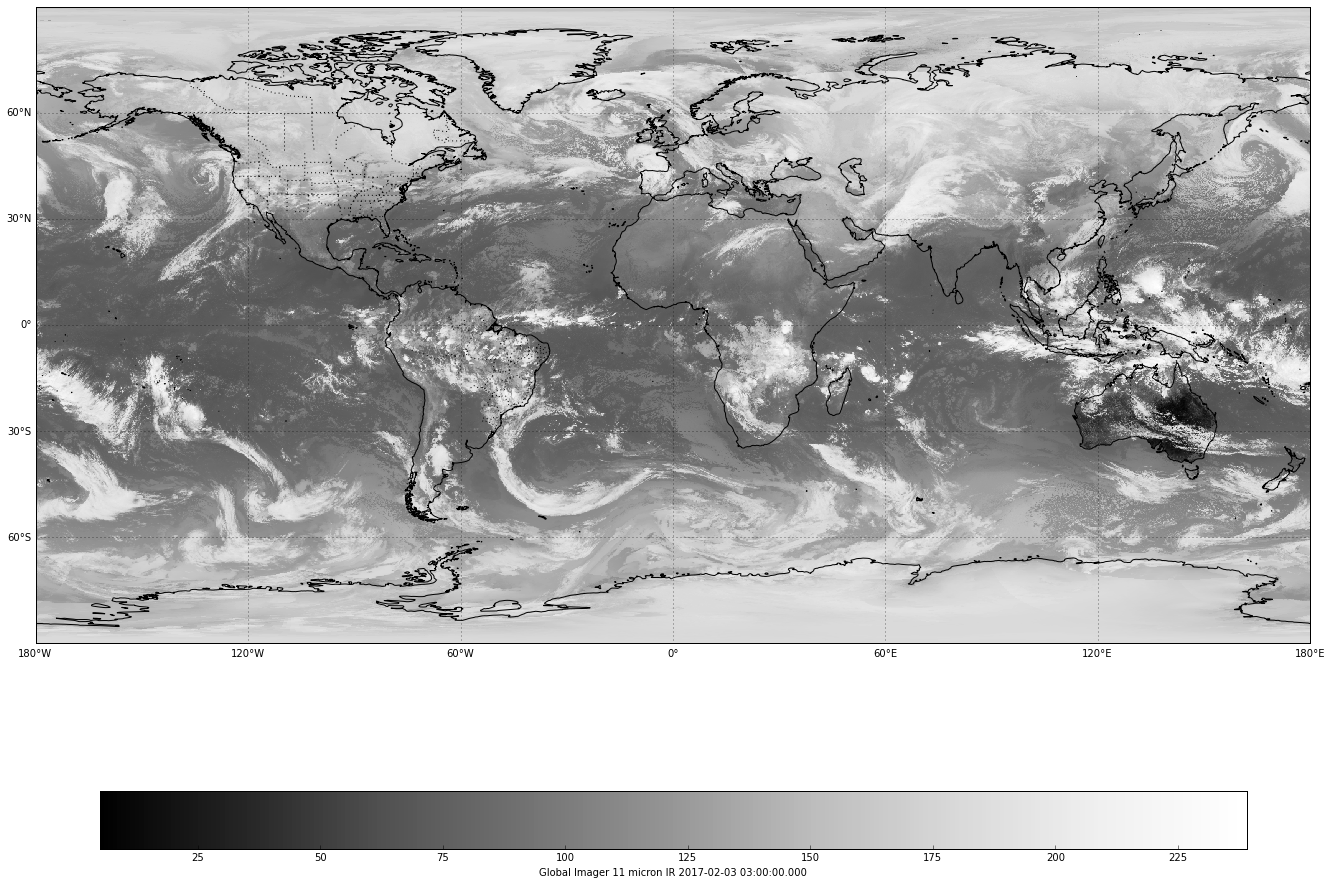

In [10]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(18,14),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map(bbox=bbox)
# State boundaries
states = cfeat.NaturalEarthFeature(category='cultural',
                                    name='admin_1_states_provinces_lines',
                                    scale='50m', facecolor='none')
ax.add_feature(states, linestyle=':')
cs = ax.pcolormesh(lons, lats, data, cmap='Greys_r')
cbar = fig.colorbar(cs, shrink=0.9, orientation='horizontal')
cbar.set_label(str(grid.getLocationName())+" " \
               +str(grid.getParameter())+" " \
               +str(grid.getDataTime().getRefTime()))
plt.tight_layout()